

## Feature Engineering

We will add some more features.

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import inv_boxcox

# supress unnecessary warnings for readability and cleaner presentation
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('bmh')

In [2]:
# reading data
df_train = pd.read_csv('use_case_data.csv')
df_score = pd.read_csv('score_data.csv')

df_train['data_type'] = 'train'
df_score['data_type'] = 'score'

In [3]:
# helper function which performs all steps of data processing which we applied during 
# Data cleaning and preprocessing
def prepare_data():
    
    # removing negative market shares
    temp = df_train[df_train['Market_Share'] >= 0]
    
    # applying boxcox
    market_share = stats.boxcox(temp['Market_Share'].values + 1e-30, lmbda=0.25)
    
    # combining train and score
    data = pd.concat([temp.drop(columns='Market_Share'), df_score],ignore_index=True)
    
    # adding response variable
    data['Market_Share'] = np.nan
    mask = data['data_type'] == 'train'
    data.loc[mask, 'Market_Share'] = market_share
    data.drop(columns='data_type', inplace=True)
    
    # changing dtype to category
    data['ITEMSCODE'] = data['ITEMSCODE'].astype('category')

    # spliting to year and month, adding to not_useful_features list
    data['LAUNCH_YEAR'], data['LAUNCH_MONTH'] = data['NPLLAUNCHDATE'].map(str).apply(
        lambda x: [x[:4], x[4:]]).str   
    
    # removing not useful features
    not_useful = ['BRMID', 'LATESTPERIODINDEX', 'NPLLAUNCHDATE', 'ISREPLACEMENT', 'BRM', 'MARKETEDBRAND',
                  'BRANDSUBFAMILY', 'NPLLAUNCHYEAR', 'RTYPE', 'ITEMSHAPE']
    
    data.drop(columns=not_useful, inplace=True)
    
    # filling missing values
    data['SPECIALFLAVOR'].fillna('NOSPECIALFLAVOR', inplace=True)
    data['TIPCOLOR'].fillna('NOTIPCOLOR', inplace=True)
    
    # transform categorical features into the appropriate type
    for c in data.columns:
        col_type = data[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            data[c] = data[c].astype('category')  
    
    print('all data shape: {}'.format(data.shape))
    return data

We will add some more features by aggregating some categorical features by numeric ones.

For example, we will calculate **mean, median, mode, std, skew** of **RETAILPACKPRICE** for each **REGION**. 

In [4]:
def aggregate(data, f_1, f_2):
    """Aggregates f_1 by f_2"""

    mean_ = '{}_{}_mean'.format(f_1, f_2)
    median_ = '{}_{}_median'.format(f_1, f_2)
    std_ = '{}_{}_std'.format(f_1, f_2)
    mode_ = '{}_{}_mode'.format(f_1, f_2)
    skew_ = '{}_{}_skew'.format(f_1, f_2)

    temp = data.groupby(f_1)[f_2].aggregate(
        {mean_: np.mean,
         std_: np.std,
         median_: np.median,
         mode_: lambda x: stats.mode(x)[0][0],
         skew_: stats.skew}
    ).reset_index()

    for x in (mean_, std_, median_, mode_, skew_):
        temp[x].fillna(0, inplace=True)

    data = data.merge(temp)
    
    # adding relative (for example product RETAILPACKPRICE / REGION mean RETAILPACKPRICE)
    relative_mean_ = '{}_{}_relative'.format(f_1, f_2)

    def relative(row):
        mean_value, f_2_value = row[mean_], row[f_2]
        if mean_value == 0 and f_2_value == 0:
            return 1.
        elif mean_value == 0 and f_2_value != 0:
            return 1e6
        else:
            return f_2_value / mean_value
        
    data[relative_mean_] = data.apply(lambda row: relative(row), axis=1)
    return data

In [5]:
def get_final_data(data, to_dummy=False, cardinality_ratio=1.):
    """
    Recives cleaned and preprocessed data, add features, high cardinality features and makes one-hot encoding.
    """
    data_copy = data.copy()

    # removing high cardinality categorical features
    if cardinality_ratio < 1.:
        n = len(data_copy)
        high_cardinalty_features = []
        for c in data_copy.columns:
            if data_copy[c].dtype.name == 'category' and len(data_copy[c].unique()) / n > cardinality_ratio:
                high_cardinalty_features.append(c)
        print('Removing {} features, which have high cardinality.'.format(high_cardinalty_features))
        data_copy.drop(columns=high_cardinalty_features, inplace=True)

    to_be_aggregated = ('REGION', 'BLDIMAGE', 'INDICATOR', 'INTERNATIONALINDICATOR',
                        'ISSTRATEGIC',  'LENCATEGORY', 'MINDICATOR',
                        'PCKT', 'TCLASS', 'THICATEGORY', 'MARKET')

    for f_1 in to_be_aggregated:
        for f_2 in numeric_fs:
            data_copy = aggregate(data_copy, f_1, f_2)

    print('all data shape after features addition: {}'.format(data_copy.shape))

    # one-hot encoding for categorical features
    if to_dummy:
        data_copy = pd.get_dummies(data_copy)
        print('all data shape after one-hot-encoding: {}'.format(data_copy.shape))

    # splitting into train and score
    mask = data_copy['Market_Share'].notnull()
    training_data, score_data = data_copy[mask], data_copy[np.invert(mask)]
    score_data.drop(columns='Market_Share', inplace=True)
    print('training data shape: {}, score data shape: {}'.format(
        training_data.shape, score_data.shape))
    return training_data, score_data

## Evaluation metrics

In [193]:
import itertools
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.base import clone
from sklearn.model_selection import KFold, train_test_split
from tabulate import tabulate

In [7]:
def plot_confusion_matrix(matrix, classes, cmap=plt.cm.Reds):
    """This function plots the normalized confusion matrix."""
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title('Normalized Confusion matrix', fontsize=17)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=15)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]),range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center", fontsize=17,
                 color="blue" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.show()
    

def plot_model_performance(y_true, y_pred, matrix):
    """
    This function plots:
        - predicted values vs actual values
        - confusion matrix
        - roc curve
    """
    print()
    
    # plotting predicted values vs actual ones
    plt.figure(figsize=(10, 10))
    plt.scatter(y_true, y_pred)
    plt.title('Actual values vs Predicted values.')
    plt.ylabel('Predicted', fontsize=12)
    plt.xlabel('Actual', fontsize=12)
    plt.show()
              
    print()
    
    # plotting confusion matrix
    plot_confusion_matrix(matrix, ['Failure', 'Success'])
    
    print()
    threshold = 0.007
    threshold_transformed = stats.boxcox(threshold, 0.25)
    binary_target = y_true > threshold_transformed
    
    fpr, tpr, _ = roc_curve(binary_target, y_pred)
    auc_score = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, lw=3, alpha=0.3, label='ROC (AUC = %0.2f)' % (auc_score))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
def scorer(y_true, y_pred):
    """Calculates differnt merics for evaluating our models."""

    threshold = 0.007
    threshold_transformed = stats.boxcox(threshold, 0.25)

    binary_prediction = y_pred > threshold_transformed
    binary_target = y_true > threshold_transformed

    """Regression metrics"""
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    explained_variance = explained_variance_score(y_true, y_pred)
    r_2 = r2_score(y_true, y_pred)

    """Classification metrics"""

    # The probability that the model ranks a random
    # positive example more highly than a random negative example.
    auc = roc_auc_score(binary_target, y_pred)

    conf_matrix = confusion_matrix(binary_target, binary_prediction)
    # true positives (TP): We predicted Y and they do have the disease.
    # true negatives (TN): We predicted N, and they don't have the disease.
    # false positives (FP): We predicted Y, but they don't have the disease.
    # false negatives (FN): We predicted N, but they do have the disease.
    tn, fp, fn, tp = conf_matrix.ravel()

    # correct labels
    total = tn + fp + fn + tp
    actual_yes = fn + tp
    actual_no = total - actual_yes

    # Overall, how often is the classifier correct?
    accuracy = (tp + tn) / total

    # Overall, how often is it wrong?
    misclassification_rate = (fp + fn) / total

    # When it is actually Y, how often does it predict Y?
    # Probability that a test result will be positive when the disease is present.
    # Recall
    tp_rate = tp / actual_yes

    # When it is actually N, how often does it predict N?
    # Probability that a test result will be negative when the disease is not present.
    specificity = tn / actual_no

    # When it is actually N, how often does it predict Y?
    # 1 - specificity
    fp_rate = fp / actual_no

    # When it predicts Y, how often is it correct?
    # Probability that the disease is present when the test is positive.
    # Positive Predictive Value or precision
    pp_value = tp / (fp + tp)

    # When it predicts N, how often is it correct?
    # Probability that the disease is not present when the test is negative.
    # Negative Predictive Value
    np_value = tn / (tn + fn)

    # The weighted average of recall and precision.
    f_score = 2 * tp_rate * pp_value / (tp_rate + pp_value)

    return {
        'rmse': rmse,
        'explained_variance': explained_variance,
        'r_2': r_2,
        'confusion_matrix': conf_matrix,
        'accuracy': accuracy,
        'tpr': tp_rate,
        'specificity': specificity,
        'fpr': fp_rate,
        'ppv': pp_value,
        'npv': np_value,
        'f_score': f_score,
        'auc': auc,
    }



**5 fold CV strategy: we will validate our models and tune hyperparameters by 5 fold CV**

In [194]:
def cv_mean_score(fold_scores):
    """Calculates model mean score based on list of each folds scores."""
    if not fold_scores:
        return
    keys = list(fold_scores[0].keys())
    data = {k: [x[k] for x in fold_scores] for k in keys if k != 'confusion_matrix'}
    return {k: (np.mean(v), np.std(v)) for k, v in data.items()}   

def cv(model, train_data, train_y, n_folds=5):
    """Helper function for doing cross validation and collecting metrics."""

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    training_metrics, validatin_metrics = [], []
    for i, (train_ind, valid_ind) in enumerate(kf.split(train_data)):
        model_ = clone(model)
        model_.fit(train_data.iloc[train_ind], train_y.iloc[train_ind])

        train_y_pred = model_.predict(train_data.iloc[train_ind])
        t_metrics = scorer(train_y.iloc[train_ind].values, train_y_pred)

        valid_y_pred = model_.predict(train_data.iloc[valid_ind])
        v_metrics = scorer(train_y.iloc[valid_ind].values, valid_y_pred)

        print('\nfold: {}\n'.format(i + 1))
        tabular_metrics = [[k, t_metrics[k], v_metrics[k]]
                           for k in t_metrics.keys()
                           if k != 'confusion_matrix']
        
        print(tabulate(tabular_metrics,
                       headers=['metric_name', 'training_set', 'validation_set'],
                       tablefmt="fancy_grid",
                       floatfmt=",.3f"))

        training_metrics.append(t_metrics)
        validatin_metrics.append(v_metrics)

    mean_t_score = cv_mean_score(training_metrics)
    mean_v_score = cv_mean_score(validatin_metrics)

    tabular_mean_metrics = [
        [k, mean_t_score[k][0], mean_t_score[k][1], mean_v_score[k][0], mean_v_score[k][1]]
        for k in mean_t_score.keys()]

    tabular_mean_metrics = tabulate(
        tabular_mean_metrics,
        headers=['metric_name', 'train: mean', 'train: std', 'valid: mean', 'valid: std'],
        tablefmt="fancy_grid",
        floatfmt=",.3f")
    return tabular_mean_metrics

In [195]:
def evaluate_model(model, data, y, training=True):
    """Evaluates model on train or test data."""
    
    if training:
        # fitting model before prediction
        model.fit(data, y)
    
    # predicition
    y_pred = model.predict(data)
    
    metrics = scorer(y, y_pred)
    plot_model_performance(y, y_pred, metrics.pop('confusion_matrix'))
    for k, v in metrics.items():
        print('{}: {:.3f}'.format(k, v))
    
    return metrics    



## Modeling

**Import librairies**

In [196]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

import lightgbm as lgb

**Preparing data: data clening, preprocessing and adding  additional features, one-hot-encoding**

In [198]:
df = prepare_data()

# split into numeric and categorical
numeric_fs = [c for c in df.columns if df[c].dtype.name != 'category' and c != 'Market_Share']
categoircal_fs = list(set(df.columns) - set(numeric_fs) - {'Market_Share'})

all data shape: (1721, 32)


In [199]:
# preparing data
training_df, score_df = get_final_data(df, to_dummy=True, cardinality_ratio=0.5)

numeric_fs = [c for c in training_df.columns if training_df[c].dtype.name != 'category' and c != 'Market_Share']
categoircal_fs = list(set(training_df.columns) - set(numeric_fs) - {'Market_Share'})

Removing ['BRANDONMARKET'] features, which have high cardinality.
all data shape after features addition: (1721, 295)
all data shape after one-hot-encoding: (1721, 1467)
training data shape: (1692, 1467), score data shape: (29, 1466)


**Train - Test split: we will keep 15% of data for final testing**

In [200]:
assert len(training_df) == len(df_train[df_train['Market_Share'] >= 0])

train, test = train_test_split(training_df, test_size=0.15, shuffle=True)
print(train.shape, test.shape)

(1438, 1467) (254, 1467)


In [201]:
# separating response variable
y_train, X_train = train['Market_Share'], train.drop(columns='Market_Share')
y_test, X_test = test['Market_Share'], test.drop(columns='Market_Share')

**Base models and their scores on 5 fold CV:**

As models we have selected 4 models: Lasso regression, Elastic Net, ExtraTress regression and Gradient tree boosting. First two models are more linear than other two. First 2 models are modifications of linear regession with additional constraints on regression coefficients. The last 2 models are more no-linear models based on decision trees.

* **LASSO Regression :**

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's **Robustscaler()** method on pipeline.

In [204]:
all_models_scores = {}

In [205]:
model_lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0003, max_iter=1e3, tol=1e-5, random_state=1))
score = cv(model_lasso, X_train, y_train)
all_models_scores['lasso'] = all_models_scores
print('\nLasso score:\n')
print(score)


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.192 │            0.266 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.613 │            0.349 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.613 │            0.349 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.861 │            0.840 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.391 │            0.393 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.969 │            0.960 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.031 │            0.040 │
├────────────────────┼────────────────┼───────

* **Elastic Net Regression :**

again made robust to outliers

In [206]:
model_enet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.8, random_state=3))
score = cv(model_enet, X_train, y_train)
all_models_scores['elastic_net'] = score
print('\nElastic Net:\n')
print(score)


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.205 │            0.269 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.560 │            0.332 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.560 │            0.332 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.851 │            0.823 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.349 │            0.328 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.967 │            0.956 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.033 │            0.044 │
├────────────────────┼────────────────┼───────

* **Extra Trees Regressor:**

In [209]:
model_extratree = ExtraTreesRegressor(
    n_estimators=200,
    max_depth=30,
    min_samples_split=2, 
    min_samples_leaf=2,
    min_weight_fraction_leaf=0.0002,
    max_leaf_nodes=None,
    max_features='auto',
    min_impurity_decrease=0.00,
    n_jobs=2
    
)

score = cv(model_extratree, X_train, y_train)
all_models_scores['extra_tree'] = score
print('\nExtraTree:\n')
print(score)


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.071 │            0.250 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.947 │            0.423 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.947 │            0.423 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.972 │            0.812 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.879 │            0.279 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.994 │            0.956 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.006 │            0.044 │
├────────────────────┼────────────────┼───────

* **LightGBM :**

In [208]:
model_lgb = lgb.LGBMRegressor(
    boosting_type='dart',
    
    objective='rmse',
    n_estimators=5000,
    learning_rate=0.3,
    
    max_depth=4,             # Specify the max depth to which tree will grow. 
    num_leaves=10,             # Number of leaves in one tree

    min_child_weight=11,     # minimal sum hessian in one leaf
    min_data_in_leaf=20,       # Min number of data in one leaf.
    
    subsample=0.75,            # Specifies the fraction of data to be used for each iteration
    subsample_freq=5,
    bagging_seed=9,
    
    colsample_bytree=0.45,  # Specifies the fraction of features to be taken for each iteration
    feature_fraction_seed=7,
    
    min_gain_to_split=0.002,    # Min gain to perform splitting
    reg_alpha=0.001,
    reg_lambda=0.,
#     max_bin=55,
    drop_rate=0.3,
    max_drop=50,
    
    n_jobs=2,
    
)

score = cv(model_lgb, X_train, y_train)
all_models_scores['gradient_boosting'] = score
print('\nLGBM:\n')
print(score)


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.040 │            0.276 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.984 │            0.299 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.983 │            0.298 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.981 │            0.812 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.935 │            0.393 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.991 │            0.925 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.009 │            0.075 │
├────────────────────┼────────────────┼───────

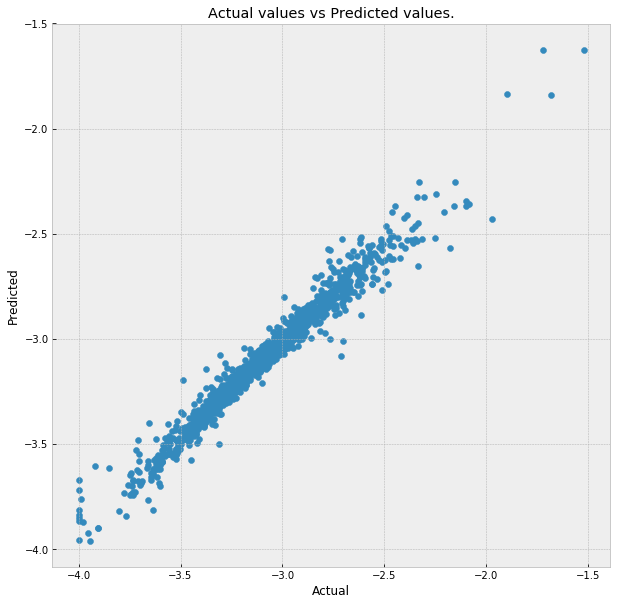

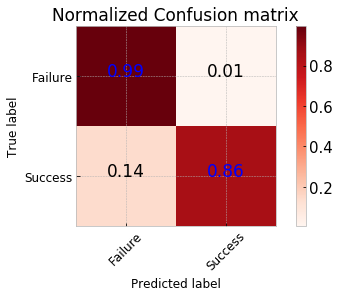

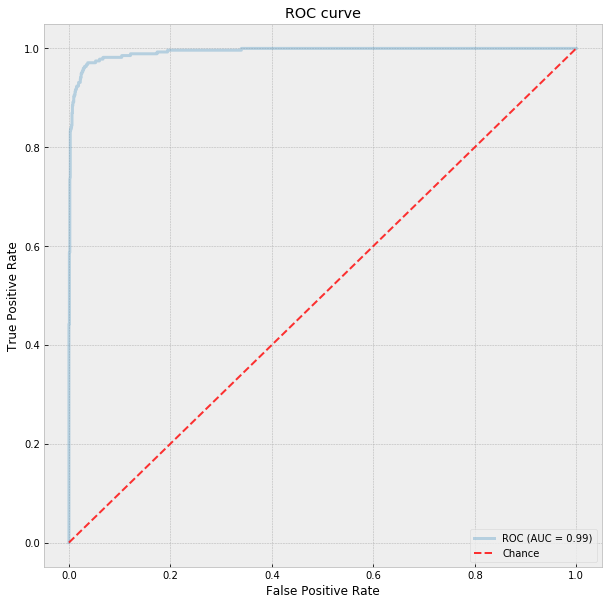

rmse: 0.064
explained_variance: 0.958
r_2: 0.958
accuracy: 0.967
tpr: 0.855
specificity: 0.994
fpr: 0.006
ppv: 0.971
npv: 0.967
f_score: 0.909
auc: 0.993


{'rmse': 0.0638868814649215,
 'explained_variance': 0.9584794208091024,
 'r_2': 0.9584794208091024,
 'accuracy': 0.9673157162726008,
 'tpr': 0.855072463768116,
 'specificity': 0.9939759036144579,
 'fpr': 0.006024096385542169,
 'ppv': 0.9711934156378601,
 'npv': 0.9665271966527197,
 'f_score': 0.9094412331406552,
 'auc': 0.9933694404948988}

In [213]:
evaluate_model(model_extratree, X_train, y_train, training=True)

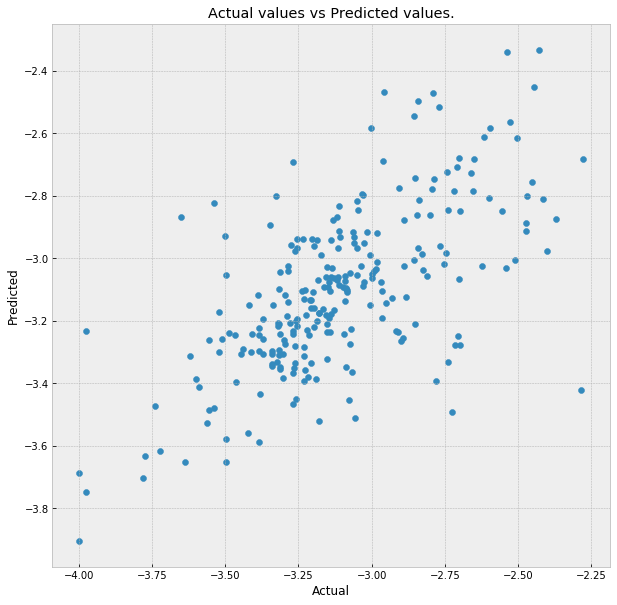

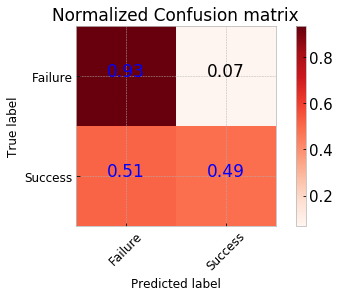

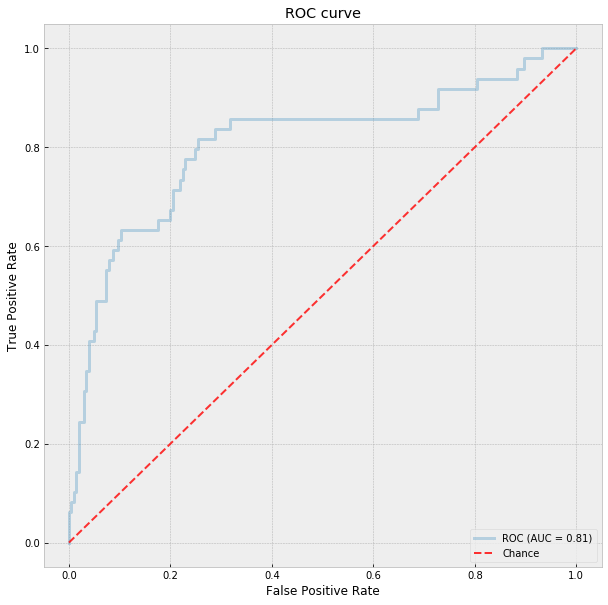

rmse: 0.246
explained_variance: 0.390
r_2: 0.390
accuracy: 0.846
tpr: 0.490
specificity: 0.932
fpr: 0.068
ppv: 0.632
npv: 0.884
f_score: 0.552
auc: 0.807


{'rmse': 0.24602188918167645,
 'explained_variance': 0.38994630806698793,
 'r_2': 0.3895357921452287,
 'accuracy': 0.8464566929133859,
 'tpr': 0.4897959183673469,
 'specificity': 0.9317073170731708,
 'fpr': 0.06829268292682927,
 'ppv': 0.631578947368421,
 'npv': 0.8842592592592593,
 'f_score': 0.5517241379310346,
 'auc': 0.8074664011946241}

In [211]:
evaluate_model(model_lgb, X_test, y_test, training=False)

In [113]:
models = [model_lasso, model_enet, model_xgb, model_lgb]

NameError: name 'model_xgb' is not defined

In [ ]:
for model in models:
    evaluate_train_test(model, X_train, y_train, X_test, y_test)
    print()

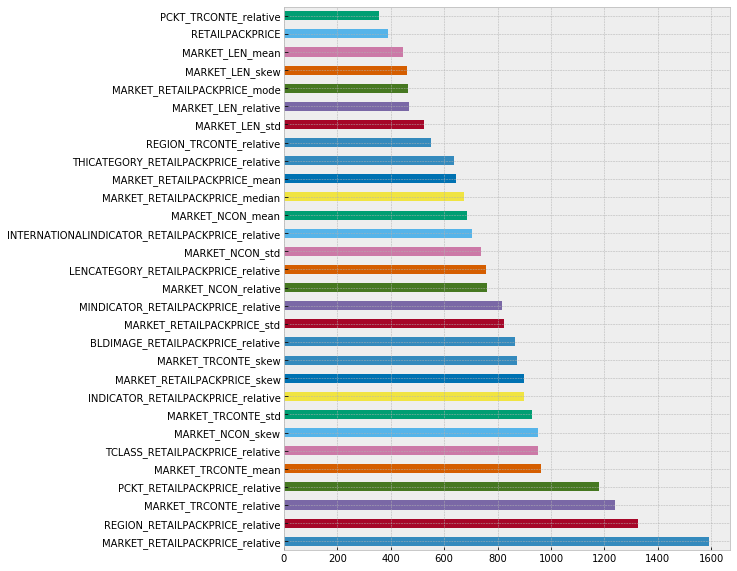

In [212]:
feat_imp = pd.Series(model_lgb.feature_importances_, index=X_train.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

In [ ]:
feat_imp = pd.Series(model_xgb.feature_importances_, index=X_train.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10));

In [ ]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [ ]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_split_gain': '{:.3f}'.format(params['min_split_gain'])
        
    }

    regressor = lgb.LGBMRegressor(
        boosting_type='gbdt',
        objective='regression',
        n_estimators=5000,
        learning_rate=0.03,
        max_depth=-1,
        min_child_weight=11,
        min_data_in_leaf=5,  
        subsample=0.8,            
        subsample_freq=5,
        bagging_seed=9,
        feature_fraction_seed=7,
        **params
    )

    score = rmsle_cv(regressor, n_folds=5)
    print(params, '{:.3f}'.format(score.mean()), '{:.3f}'.format(score.var()))
    return score.mean()


space = {
    'num_leaves': hp.quniform('num_leaves', 32, 128, 4),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 0.8),
    'min_split_gain': hp.uniform('min_split_gain', 0.0, 0.1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30)

In [ ]:
best

In [ ]:
best['num_leaves'] = 128